In [1]:
import os
import numpy as np
import scipy as sp
import robot_data_treatment
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

## RoboCin Dataset

Below is a diagram of a roboCin SSL robot, where 4 wheels with their respective speeds ($[\omega_1,\omega_2,\omega_3,\omega_4]$) move the robot in order to create velocities $[v_x, v_y, \omega]$.

![robot dinamics](../imgs/robot_model2.png)

The wheel velocities can be translated into robot velocities using the following matrix transformation:

$$
    C = (1/r)\begin{bmatrix}
    -\sin{\theta_1} & \cos{\theta_1} & l \\
    -\sin{\theta_2} & \cos{\theta_2} & l \\
    -\sin{\theta_3} & \cos{\theta_3} & l \\
    -\sin{\theta_4} & \cos{\theta_4} & l \\
\end{bmatrix} 
$$

$$
\begin{bmatrix}
    v_x\\
    v_y\\
    \omega\\
\end{bmatrix} = C \begin{bmatrix}
    \omega_1\\
    \omega_2\\
    \omega_3\\
    \omega_4\\
\end{bmatrix}
$$

For our robot, $\theta_1 = \pi/3,\ \theta_2 = \pi-\pi/4,\ \theta_3 = \pi + \pi/4,\ \theta_4 = 2\pi-\pi/3,\ r = 0.025m,\ l = 0.083m $, where the $\theta$'s are the angles of each wheel relative to x-axis, $r$ is the radius of each wheel and $l$ is the distance between the wheels and the center of the robot.

A dataset was collected of different robots performing squared trajectories and logging a ground-truth pose (x, y, and angle coordinates) from an overhead camera, wheel speeds and timestamps of each measurement. A snippet of the collected data can be seen below.

As this is a transformation from 4 dimensions to 3 dimensions, the imprecision of each dimensions in the "wheel frame" is combined when translated to "robot frame". This model doesn't allow accurate tracking of the position of the robot in global frame of reference. Our goal is to verify if a data-driven approach can properly model the system dynamics in a way that a model-based estimation can't, as these errors are coming mostly from our poor definition of the model, so adding processes noises on a Kalman Filter (or the extended version) doesn't perform as well as intended.



,ID,ROBOT_X,ROBOT_Y,ROBOT_W,ROBOT_M1,ROBOT_M2,ROBOT_M3,ROBOT_M4,VISION_X,VISION_Y,VISION_W,BEHAVIOR,LABEL,TIMESTAMP,PCKT,CHANGE_STATE,GT_X,GT_Y,GT_THETA,GT_VX,GT_VY,GT_W
0,0,0.563,-2.490,1.6054,0.46,2.30,-1.38,-1.15,0.563227,-2.49075,1.58844,2,0,43918,146,NaN,0.000000,0.00000,1.58844,0.000000,0.000000,0.000000
1,0,0.563,-2.490,1.6054,1.61,1.15,-1.61,-1.38,0.563222,-2.49071,1.58844,2,0,43932,148,NaN,-0.000005,0.00004,1.58844,-0.000018,0.000143,0.000000
2,0,0.563,-2.489,1.6054,2.07,0.69,-1.15,-1.84,0.563162,-2.49063,1.58844,2,0,43943,150,NaN,-0.000065,0.00012,1.58844,-0.000291,0.000506,0.000000
3,0,0.563,-2.489,1.6054,1.38,1.38,-1.61,-2.30,0.563141,-2.49058,1.58844,2,0,43950,151,NaN,-0.000086,0.00017,1.58844,-0.000441,0.000864,0.000000
4,0,0.563,-2.488,1.6058,2.07,1.61,-2.07,-2.76,0.563599,-2.49025,1.59640,2,0,43961,153,NaN,0.000372,0.00050,1.59640,0.001641,0.002364,0.036182


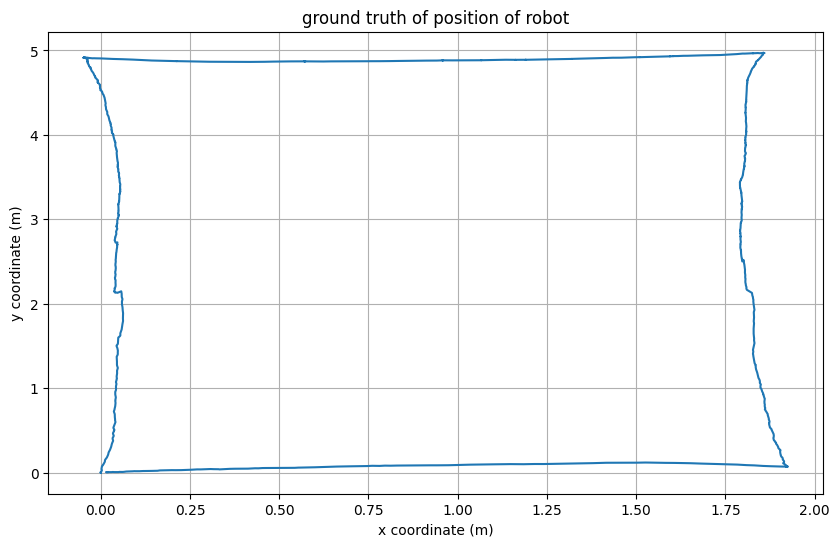

In [87]:
#data_generator = DataGenerator('dinos.txt')
data0, x0, y0 = robot_data_treatment.dataGet("../data/quadrado_opt_1_1.csv")
_, x1, y1 = robot_data_treatment.dataGet("../data/quadrado_opt_1_2.csv")
_, x2, y2 = robot_data_treatment.dataGet("../data/quadrado_opt_1_3.csv")
_, x3, y3 = robot_data_treatment.dataGet("../data/quadrado_opt_1_4.csv")
_, x4, y4 = robot_data_treatment.dataGet("../data/quadrado_opt_1_5.csv")
_, x5, y5 = robot_data_treatment.dataGet("../data/quadrado_opt_2_1.csv")
_, x6, y6 = robot_data_treatment.dataGet("../data/quadrado_opt_2_2.csv")
_, x7, y7 = robot_data_treatment.dataGet("../data/quadrado_opt_2_3.csv")
_, x8, y8 = robot_data_treatment.dataGet("../data/quadrado_opt_2_4.csv")
_, x9, y9 = robot_data_treatment.dataGet("../data/quadrado_opt_2_5.csv")

x0 = x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9
y0 = y0 + y1 + y2 + y3 + y4 + y5 + y6 + y7 + y8 + y9

sequenceLength = 10
trainTuple, valTuple, testTuple = robot_data_treatment.createTestTrainSets(x0, y0, sequenceLength, trainRatio=0.8, valRatio=0.1, testRatio=0.1)

display(HTML(data0.head(5).to_html()))

robot_data_treatment.dataPlotMulti([data0[' GT_X']], [data0[' GT_Y']], plotTitle="ground truth of position of robot")



class RobotDataset(Dataset):
    def __init__(self, data, targets):
        # Data: sequences of (wheel_velocities + orientation), shape: (num_sequences, 10, input_size)
        # Targets: global velocities, shape: (num_sequences, 2)
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

data = []
targets = []
for x,y in trainTuple:
    data.append(x)
    targets.append(y)

data = np.array(data)
targets = np.array(targets)
# Create Dataset and DataLoader
batch_size = 4
dataset = RobotDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## RNN Model

The model was kept close to [Kaggle's example](https://www.kaggle.com/code/fareselmenshawii/rnn-from-scratch) but with changes in relation to input/output dimensions, how the backpropagation and loss were calculated.

### inputs and outputs

Input of the model is now a sequence of the following vector:

$$
x_k = \begin{bmatrix}
    \omega_1\\
    \omega_2\\
    \omega_3\\
    \omega_4\\
    \theta\\
\end{bmatrix}_k
$$

While the output has the following format:
$$
y_k = 
\begin{bmatrix}
    v_x \\
    v_y \\
    \omega \\
\end{bmatrix}_k
$$

$y_k$ are the velocities in relation to a global reference frame, so the $\theta$ angle was added to the input vector as an expectation the system would learn to also perform the rotation matrix. $\theta$ is taken from the vision system, but the assumption here is that if we can provide the angle, can the robot have its own physical system modelled properly?

The sequence given to the model is a sequence of 10 timestamps, alongside their groundtruths.

### loss function and backpropagation

The new loss function can be defined as follows:

$$
L = \sum\limits_{i=0}^{N-1}{(\frac{1}{(N-i)}(\tilde{y}_i - gt_i)^2)}
$$

$$
Loss = L[0] + L[1] + L[2]
$$

This way, we weigh more the end of the sequence than the beginning. But also give equal importance to all three elements of the output vector

Consequently, the backpropagation is now:

$$

\frac{\partial{L}}{\partial{y_i}}_t = \frac{1}{(N-t)}(\tilde{y}_i - gt_{t,i})^2
$$


In [92]:
class RNN2_robot(nn.Module):
    def __init__(self, input_size, batch_size, hidden_size, output_size, device, num_layers=1):
        super(RNN2_robot, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True).to(device)

        # Fully connected layer to map from hidden state to output
        self.fc = nn.Linear(hidden_size, output_size).to(device)
        self.h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        #print(self.rnn.device)
    def forward(self, x):
        # Initialize hidden state with zeros

        # Pass through RNN
        N = 10 # number of frames in sequence - should be extracted from x..
        h = self.h0
        out = []
        y, h = self.rnn(x, h)

        split_tensors = torch.split(y, 1, dim=1)
        split_tensors = [tensor.squeeze(1) for tensor in split_tensors]

        for i in range(len(split_tensors)):
            temp = self.fc(split_tensors[i])
            out.append(temp)
        # Take the output of the last time step and pass it through the fully connected layer

        #out.append(y)

        return out
# Parameters
input_size = 5  # Example: (wheel velocities + orientation)
hidden_size = 500
output_size = 3  # Global velocities (vx, vy)
num_layers = 10
learning_rate = 0.001
num_epochs = 30


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Initialize model, loss function and optimizer
model = RNN2_robot(input_size, batch_size, hidden_size, output_size, device, num_layers)
criterion = nn.MSELoss()  # Use mean squared error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

cuda


In [93]:
# Training Loop
model.train()  # Set model to training mode

losses = []
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(dataloader):

        # Move tensors to the appropriate device (GPU if available)
        inputs = inputs.to(device)
        labels = labels.to(device)
        if inputs.shape[0] != batch_size:
            continue

        # Forward pass
        outputs = model(inputs)
        outputs = torch.stack(outputs,dim=1)
        #print(outputs)
        #print(labels)
        loss = criterion(outputs, labels)
        losses.append(loss)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/30], Loss: 0.2092
Epoch [20/30], Loss: 0.1247
Epoch [30/30], Loss: 0.1141


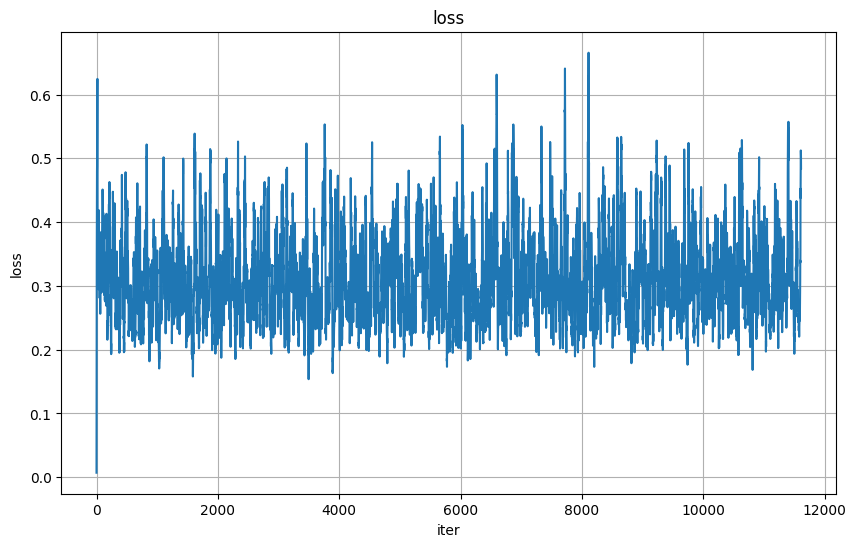

In [94]:
losses_cpu = []
for loss in losses:
    losses_cpu.append(loss.cpu().detach().numpy())
numberFilterCoefs = 15
losses_cpu = scipy.signal.lfilter([1.0/numberFilterCoefs]*numberFilterCoefs, 1, losses_cpu)
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses_cpu)), losses_cpu)#, marker='o', linestyle='-')
plt.title("loss")
plt.xlabel("iter")
plt.ylabel("loss")

plt.grid(True)
plt.show()

## Results after training

The loss function above doesn't converge, which could suggest that either we don't have enough training data, or our model is incomplete, with Fully Connected Layers for example, at the end, combining a big output vector of the RNN (size of hidden states), into the output size of 3. 

In [95]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    test_inputs = torch.rand(1, 10, input_size)  # Example test input (1 sequence of length 10)
    test_outputs = model(test_inputs)
    print(f'Predicted global velocities: {test_outputs}')

RuntimeError: Expected hidden size (10, 1, 500), got [10, 4, 500]

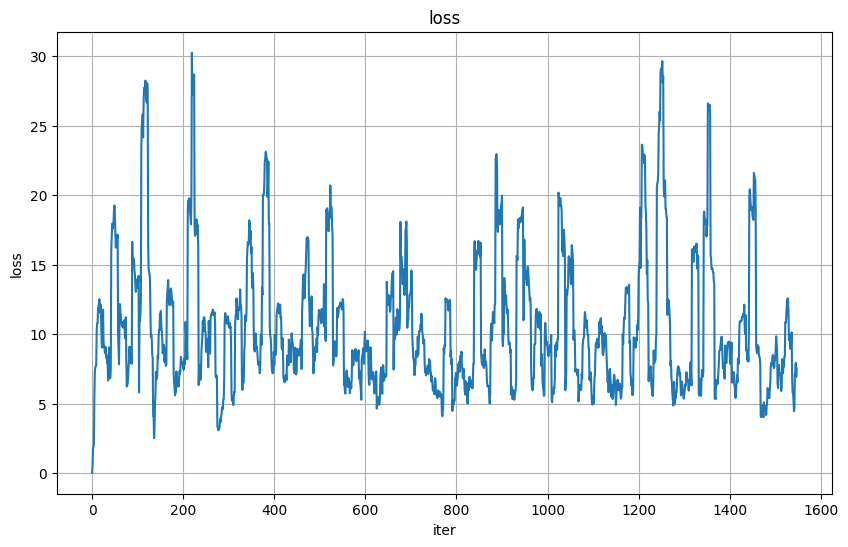

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(rnn.losses_filtered)), rnn.losses_filtered)#, marker='o', linestyle='-')
plt.title("loss")
plt.xlabel("iter")
plt.ylabel("loss")

plt.grid(True)
plt.show()